<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/AlexNet(TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 패키지 로드

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 8.7 MB/s 
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# import
import numpy as np
import pandas as pd
import os
import sklearn 
import tensorflow as tf
from tensorflow.keras.layers import Input , Conv2D  ,ReLU, MaxPooling2D,  BatchNormalization,  Dense, Dropout , Flatten, Softmax, ZeroPadding2D, add, Add,  Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import SGD
import albumentations as A
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping 


initializer = initializers.RandomNormal(mean=0., stddev=0.01)

# 2. 논문 분석

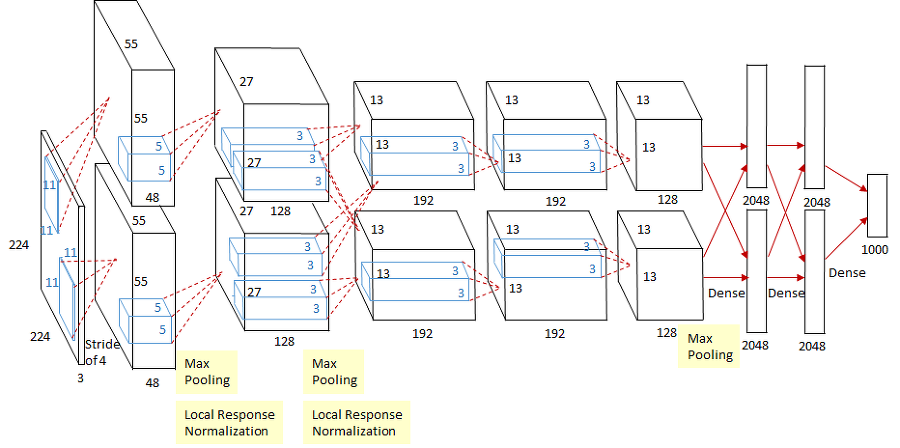



*   논문 그림에는 input이 224\*224 사이즈이지만, 실제로 227\*227 사이즈이다. 정확히는 256이고 227사이즈로 randomcrop한 것

*   논문 당시에는 첫번째 레이어(Conv)에서 두갈래로 나눠 들어갔다. 이는 GPU 메모리 이슈로 반반 나누어 GPU를 사용 한 것이다. 이 때 나뉘어 지고 나서 2, 4, 5 conv layer는 같은 GPU의 층만 받아오지만, 3번째 conv layer와 모든 FC레이어들은 이전 층의 모든 뉴런가 연결 된다. 이는 단순히 메모리 부족문제 뿐만 아니라 논문에서는 정확도를 높이기 위한 추가적인 트릭이라 설명한다.
대부분 사람들의 코드가 이를 구현 하지 않았지만 이번에 직접 구현해겠다.


* 구현에서는 LRN이 사용되었지만, 나는 batch 노말을 사용하겠다. 논문에서 LRN을 ReLU다음에 사용했기에 위치는 그대로 가져간다. 

* 실제로 1000개의 데이터를 사용하기가 어려우므로 CIFAR10 데이터 세트를 이용할 예정이라 마지막 출력층을 10개로 조정

* 그 외 디테일한 내용 
    * 데이터 증강에 pca를 이용한 RGB변경 , crop  사용
    * 초기 학습률 0.01, weight decay 0.0005, 모멘텀 0.9, 배치size 128
    * 이후 에러율 개선이 멈추면 학습률 나누기 10
    * 약 90 epoch
    * 가중치 초기값은 N(0,0.01)을 따른다.
    * bias는 초기값 1로
    * 스캐일링은 평균을 빼서한다. 이 경우 densenet 방식(torch)와 비슷하므로 densenet의 preprocess_input 사용







# 모델 구현

In [ ]:
# 모델 구현
# functional API 방식으로 구현.
kernel_initializer=initializers.RandomNormal(stddev=0.01),
# 입력층
input = Input(shape=(227, 227, 3) )


# 첫 번째 Conv층(a와 b로 48개의 필터씩 나누어 들어간다)
# CNN, ReLU, BN, MaxPool 순(논문 순서대로)
layer1_a = Conv2D(filters= 48, kernel_size=(11,11), strides=(4,4), padding='valid',  kernel_initializer=initializer, bias_initializer='ones')(input)
layer1_b = Conv2D(filters= 48, kernel_size=(11,11), strides=(4,4), padding='valid',  kernel_initializer=initializer, bias_initializer='ones')(input)

layer1_a = ReLU()(layer1_a)
# LRN 대신 사용.
layer1_a= BatchNormalization()(layer1_a) 
layer1_a = MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer1_a)

layer1_b = ReLU()(layer1_b)
# LRN 대신 사용.
layer1_b= BatchNormalization()(layer1_b) 
layer1_b = MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer1_b)


# 두 번째 Conv층
layer2_a = Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding='same',  kernel_initializer=initializer, bias_initializer='ones')(layer1_a)
layer2_a = ReLU()(layer2_a)
layer2_a = BatchNormalization()(layer2_a)
layer2_a = MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer2_a)

layer2_b = Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding='same',  kernel_initializer=initializer, bias_initializer='ones')(layer1_b)
layer2_b = ReLU()(layer2_b)
layer2_b = BatchNormalization()(layer2_b)
layer2_b = MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer2_b)


# 세 번째 Conv층
# 이번 층에서 다시 묶인다.
# 결국 하나의 구조로 쌓였다가. 다시 나가는 형식과 동일한 효과
layer3 = tf.keras.layers.concatenate([layer2_a, layer2_b], axis=-1)

layer3_a = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding="same",  kernel_initializer=initializer, bias_initializer='ones')(layer3)
layer3_a = ReLU()(layer3_a)

layer3_b = Conv2D(filters=192,  kernel_size=(3,3), strides=(1,1), padding="same",  kernel_initializer=initializer, bias_initializer='ones')(layer3)
layer3_b = ReLU()(layer3_b)

# 네 번째 Conv층
layer4_a = Conv2D(filters=192,  kernel_size=(3,3), strides=(1,1), padding="same",  kernel_initializer=initializer, bias_initializer='ones')(layer3_a)
layer4_a = ReLU()(layer4_a)

layer4_b = Conv2D(filters=192,  kernel_size=(3,3), strides=(1,1), padding="same",  kernel_initializer=initializer, bias_initializer='ones')(layer3_b)
layer4_b = ReLU()(layer4_b)

# 다섯 번째 Conv층
layer5_a = Conv2D(filters=128,  kernel_size=(3,3), strides=(1,1), padding="same",  kernel_initializer=initializer, bias_initializer='ones')(layer4_a)
layer5_a = ReLU()(layer5_a)
layer5_a = MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer5_a)

layer5_b = Conv2D(filters=128,  kernel_size=(3,3), strides=(1,1), padding="same",  kernel_initializer=initializer, bias_initializer='ones')(layer4_b)
layer5_b = ReLU()(layer5_b)
layer5_b = MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer5_b)


# 다시 묶이고 Faltten 후 FC 3번

# 여섯 번째 FC(Dense) 층
# Dense 층 부터는 dropout이 적용
layer6 = tf.keras.layers.concatenate([layer5_a, layer5_b], axis=-1)
layer6 = Flatten()(layer6)

layer6 = Dense(units=4096,  kernel_initializer=initializer, bias_initializer='ones')(layer6)
layer6 = ReLU()(layer6)
layer6 = Dropout(rate=0.5)(layer6)

# 일곱 번째 FC(Dense) 층
layer7 = Dense(units=4096,  kernel_initializer=initializer, bias_initializer='ones')(layer6)
layer7 = ReLU()(layer7)
layer7 = Dropout(rate=0.5)(layer7)


# 여덟 번째 층, 분류 포함
# CIFAR10을 사용 할 것이기 때문에 10개로 나오도록
layer8 = Dense(units=10)(layer7)
output = Softmax()(layer8)


model = tf.keras.models.Model(inputs=input, outputs=output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 48)   17472       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 55, 55, 48)   17472       input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 55, 55, 48)   0           conv2d[0][0]                     
______________________________________________________________________________________________

## 모델 시각화

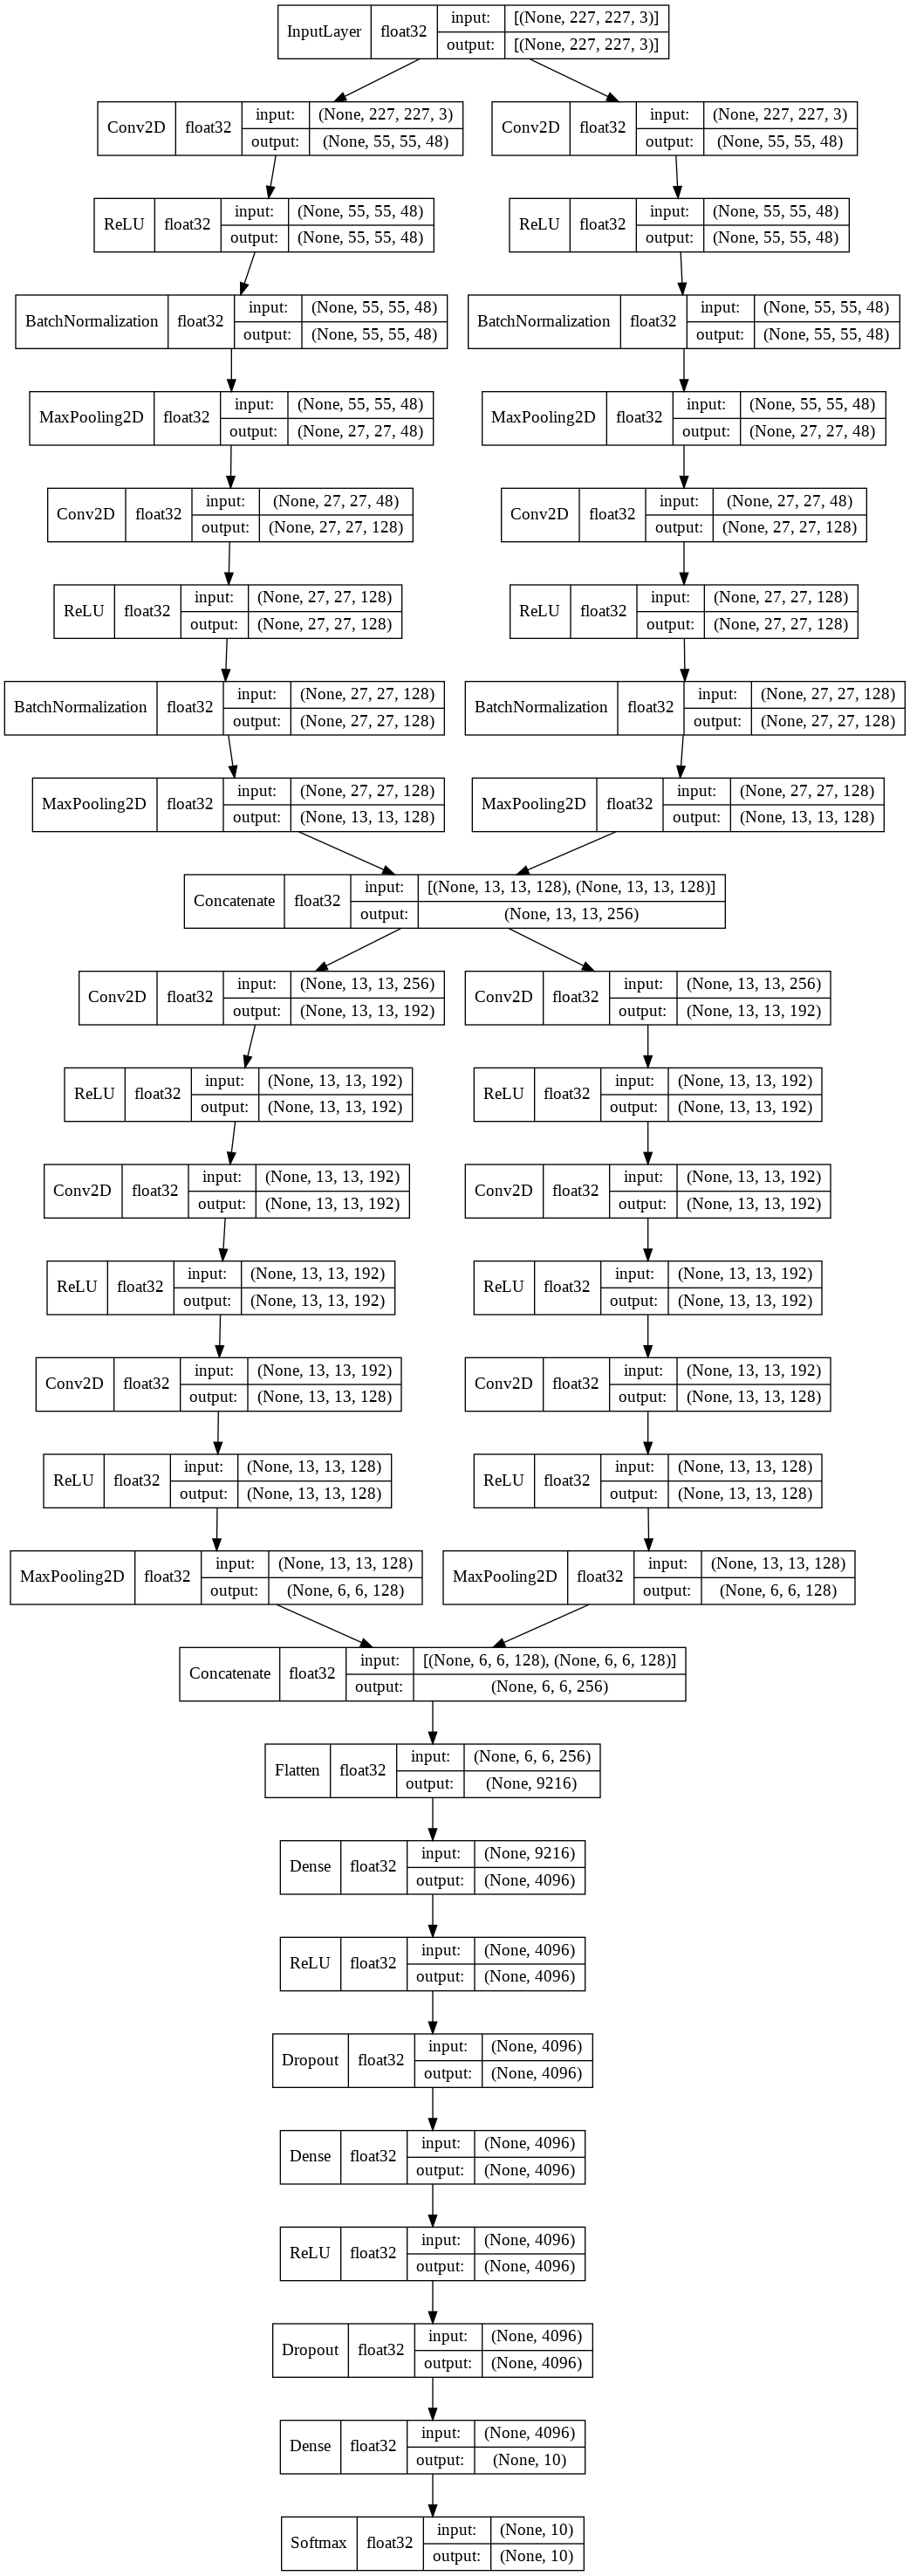

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, show_dtype=True)

# CIFAR10 전처리

## 데이터 로드 및 분할

In [ ]:
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

In [ ]:
(tr_im, tr_lb), (test_images, t_lb) = cifar10.load_data()

# 웟핫 인코딩
tr_oh_lb = to_categorical(tr_lb)
test_labels = to_categorical(t_lb)

# 훈련 세트 분할
train_images,  val_images , train_labels, val_labels = train_test_split(tr_im,tr_oh_lb, test_size=0.2 ,random_state = 403)


print(train_images.shape, train_labels.shape,val_images.shape, val_labels.shape,test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 2s 0us/step
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


## Sequence Dateset 생성

ram 부족해결 + albu 사용을 위해(배치단위 입력)

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import preprocess_input as dense_pr_input
class DataSet(Sequence): 
    def __init__(self, images_array, labels, batch_size, image_size=(256,256), augmentor=None, shuffle=False, pre_func =None):
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentor= augmentor
        self.pre_func = pre_func
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            self.on_epoch_end()
            pass

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        pre_im_batch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        image_batch = np.zeros((pre_im_batch.shape[0],self.image_size[0],self.image_size[1], 3), dtype='float32')

        for i in range(pre_im_batch.shape[0]):
            image = cv2.resize(pre_im_batch[i], self.image_size )

            if self.augmentor is not None:
                image = self.augmentor(image=image)['image'] 

            if self.pre_func is not None:
                for func in self.pre_func:
                    image = func(image)

            image = cv2.resize(image, self.image_size )

            image_batch[i] = image
                
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)



## 증강

In [ ]:
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2)

])

# fit 및 평가

In [ ]:
model.compile(optimizer=SGD(lr=0.01, momentum= 0.09,decay =0.0005 ), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_dataset = DataSet(train_images, train_labels, batch_size=64, augmentor=augmentor, shuffle=True, pre_func = [dense_pr_input])
val_dataset = DataSet(val_images, val_labels, batch_size=64, augmentor=None, shuffle=False, pre_func = [dense_pr_input])

In [ ]:
# 3번 validation error 가 개선되지 않으면 lr에 0.1곱함
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='min', verbose=1)
# 3번 동안 개선이 없다면 조기종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [ ]:
history = model.fit(train_dataset, epochs=30, 
                    validation_data=val_dataset ,
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/30
625/625 [==============================] - 108s 147ms/step - loss: 2.4368 - accuracy: 0.2231 - val_loss: 1.8414 - val_accuracy: 0.2880
Epoch 2/30
625/625 [==============================] - 94s 151ms/step - loss: 1.7713 - accuracy: 0.3298 - val_loss: 1.6365 - val_accuracy: 0.4098
Epoch 3/30
625/625 [==============================] - 94s 150ms/step - loss: 1.6355 - accuracy: 0.3913 - val_loss: 1.5219 - val_accuracy: 0.4521
Epoch 4/30
625/625 [==============================] - 94s 150ms/step - loss: 1.5558 - accuracy: 0.4213 - val_loss: 1.4841 - val_accuracy: 0.4567
Epoch 5/30
625/625 [==============================] - 90s 145ms/step - loss: 1.4952 - accuracy: 0.4484 - val_loss: 1.4614 - val_accuracy: 0.4659
Epoch 6/30
625/625 [==============================] - 94s 151ms/step - loss: 1.4463 - accuracy: 0.4669 - val_loss: 1.3427 - val_accuracy: 0.5183
Epoch 7/30
625/625 [==============================] - 90s 143ms/step - loss: 1.4020 - accuracy: 0.4843 - val_loss: 1.3086 - val_a

In [ ]:
# 평가
test_dataset = DataSet(test_images, test_labels, batch_size=64, pre_func = [dense_pr_input])
print(model.evaluate(test_dataset))

